# Lending Club Case Study

<strong>Objectives</strong>

Using EDA, the company wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default. The company can utilise this knowledge for its portfolio and risk assessment.

<strong>How Objectives will be utilized?</strong>

When the company receives a loan application, based on above indicators, the company wants to make a decision for loan approval based on the applicant’s profile. The decision should help in not losing the business to the company if the applicant is able to pay and at the same time, do not enter in to credit loss (financial loss) to the company if the applicant is not able to pay.

<br></br>
<strong>Assumptions</strong>

1. The company allows a loan to remain delinquent for a period of time before considering it as default.

<br></br>
<strong>Decisions</strong>

1. Considering assumption 1, we are not considering the column 'mths_since_last_delinq' as part of dataset since our goal is to identify factors which can help even prior approving the loan but not after the applicant has delinquent the loan which happens once the loan is approved.

<br></br>
<strong>Approach</strong>

1. As a first step, ensure the dataset is clean. As we are not sure which parameter or variable (column) would have impact on defaulting, the approach objective is to retain clean data including whatever possible columns. <br>Here, we perform Data Cleaning Steps by following the checklist: Fix rows and columns, Missing Values, Standardise Numbers, Standardise Text, Fix Invalid Values and Filter Data
2. Once the above master dataset is created, we try to make subsets appropriately to assess the impacts of variables.

<br></br>

### Common Imports

In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

## Data Extraction

In [163]:
loans_df = pd.read_csv('loan.csv',encoding='utf-8')

/Users/aarora7/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Data Cleaning

In [164]:
#Check if there any columns, with all rows null. Remove such columns
loans_df = loans_df.dropna(how='all',axis=1)

In [165]:
#Check if there are columns with lots of data missing
(loans_df.isnull().sum(axis = 0)/len(loans_df)*100).sort_values(ascending=False)

next_pymnt_d                  97.129693
mths_since_last_record        92.985372
mths_since_last_delinq        64.662487
desc                          32.580507
emp_title                      6.191303
emp_length                     2.706650
pub_rec_bankruptcies           1.754916
last_pymnt_d                   0.178765
chargeoff_within_12_mths       0.140998
collections_12_mths_ex_med     0.140998
revol_util                     0.125891
tax_liens                      0.098195
title                          0.027696
last_credit_pull_d             0.005036
collection_recovery_fee        0.000000
acc_now_delinq                 0.000000
application_type               0.000000
url                            0.000000
pymnt_plan                     0.000000
loan_status                    0.000000
issue_d                        0.000000
verification_status            0.000000
annual_inc                     0.000000
home_ownership                 0.000000
delinq_amnt                    0.000000


In [166]:
'''
next_pymnt_d               97.129693
mths_since_last_record     92.985372
mths_since_last_delinq     64.662487
'''
#It is observed that these columns have a large amount of data missing, so we can safely remove these
loans_df = loans_df.drop(['mths_since_last_record','next_pymnt_d'], axis=1)                     

In [167]:
# From above, we could see more nulls are in column : mths_since_last_delinq

# After checking metadata, this column indicates 'The number of months since the borrower's last delinquency.'.

# Delinquency after certain period leads to defaulting. 
# It might be a important paramter to assess but by considering the decision # 1, proceeding to drop column due to
# below assessment.

# Prior removing the column, if we check loan status:

loans_df.loan_status.value_counts()

#Fully Paid     32950
#Charged Off     5627
#Current         1140

# If we try to remove the column, the loan status would become:

tmp = loans_df

tmp = tmp[~pd.isnull(tmp['mths_since_last_delinq'])]

loans_df.loan_status.value_counts()

#Fully Paid     11530
#Charged Off     2142
#Current          363

# Retaining the column will remove records of 'Charged Off' which is our target of assessment.
# Also, the Current records reduces by 70%, which might be useful to understand potential defaulters.

# Hence dropping the column

loans_df = loans_df.drop(['mths_since_last_delinq'], axis=1) 

In [168]:
#Check if there are columns with just 1, or 2(null included) unique value, which makes them useless
for col in loans_df.columns:
    unique_vals = loans_df[col].unique()
    num_uniques = len(unique_vals)
    if num_uniques <= 2:
        print (col, unique_vals)

term [' 36 months' ' 60 months']
pymnt_plan ['n']
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
tax_liens [ 0. nan]


#### Removing the following columns, since they don't contribute to any variance
pymnt_plan ['n']
initial_list_status ['f']
collections_12_mths_ex_med [ 0. nan]
policy_code [1]
application_type ['INDIVIDUAL']
acc_now_delinq [0]
chargeoff_within_12_mths [ 0. nan]
delinq_amnt [0]
tax_liens [ 0. nan]

In [169]:
loans_df = loans_df.drop(['pymnt_plan','initial_list_status','policy_code','delinq_amnt','acc_now_delinq','application_type','collections_12_mths_ex_med','chargeoff_within_12_mths','tax_liens'], axis=1)

In [171]:
# Dropping irrelevant columns considering the Objective, and reviewing the loan metadata
#url does not add any value
#desc is highly variant, and in natural language, so not analysing
#member_id: Unique variable (add id is already present anyways)

loans_df.issue_d.value_counts()
#Dec-11    2260
#Nov-11    2223
#Col: earliest_cr_line: The month the borrower's earliest reported credit line was opened. Not significant for assessments.
#Dataset is between 2007 to 2011. There is no objective in analyzing the trends of defaulting across years.
loans_df.earliest_cr_line.value_counts()

#Nov-98    370
#Oct-99    366
loans_df.last_pymnt_amnt
#Not helpful column
loans_df.last_credit_pull_d
# The most recent month LC pulled credit for this loan, since this happens only after loan has been given

#Col: revol_bal: Total credit revolving balance
#https://www.creditcards.com/glossary/term-revolving-balance.php
loans_df.revol_bal.describe()
#Col: revol_util: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
loans_df.revol_util.describe()
#considering, revol_util column is available in percentage, it is safe to drop revol_bal.
loans_df.recoveries.describe()
#This is a post excersie after defaulting. Might not be helpful column.
unwantedCols = ['member_id', 'url', 'desc','last_credit_pull_d','last_pymnt_amnt','revol_util','recoveries','last_pymnt_d']

loans_df = loans_df.drop(unwantedCols, axis=1)

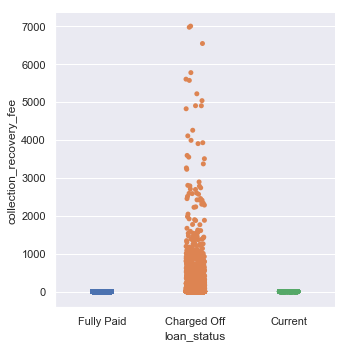

In [172]:
sns.catplot(x="loan_status", y="collection_recovery_fee", data=loans_df);
#This fee would have high values only for defaulters, so not useful for prediction 
loans_df = loans_df.drop('collection_recovery_fee', axis=1)

In [174]:
#Cols: zip_code and addr_state
loans_df.zip_code.value_counts()
#Eg:
#100xx    597
#945xx    545

loans_df.addr_state.value_counts()
#state codes are uniquely available
#Eg:
#CA    7099
#NY    3812

# In order to check defaulters are more on a specific state and a location (though zipcode is partially available),
# better to retain the data. Also, combining both state and zip code to form a unique identifier - 'addr_state_zip'
loans_df['addr_state_zip'] = loans_df.addr_state + "_" + loans_df.zip_code
'''
NY_100xx    597
CA_945xx    544
NY_112xx    515
IL_606xx    503
'''
loans_df.addr_state_zip.value_counts()
#As we could see zip_code with 945xx is having 545 records, 
# now after combining, we could see 945xx with state CA is having 544 records.
# Definitely, addr_state_zip brings some uniqueness for locality.
#Dropping zip_code which is now not required

loans_df = loans_df.drop(['zip_code'], axis=1)

#### Remove columns that are extremely correlated from each other

In [175]:
threshold = 0.98
# Create correlation matrix
corr_matrix = loans_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.98
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

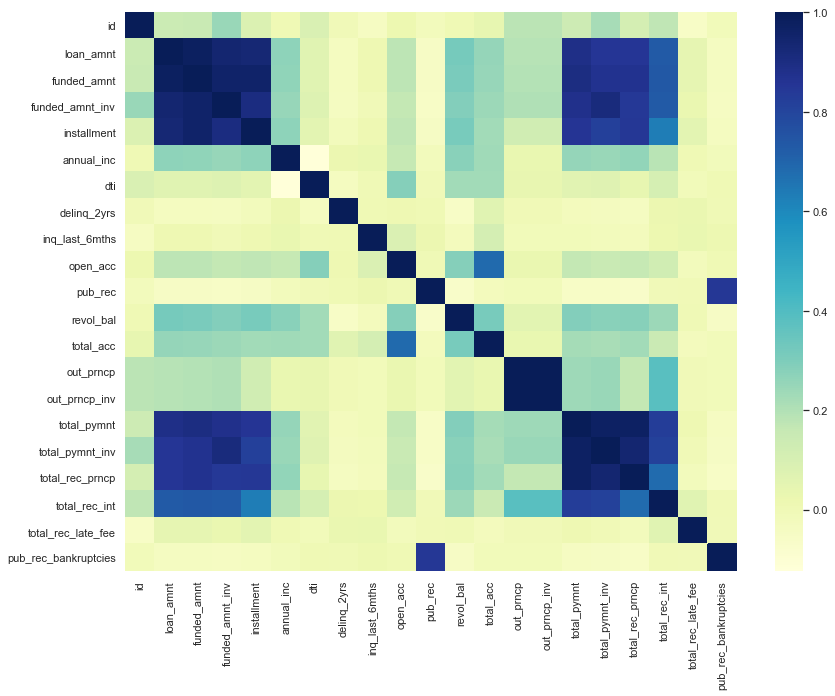

In [176]:
#Correlation heatmap
sns.set(rc={'figure.figsize':(13.7,10.27)})
sns.heatmap(loans_df.corr(), vmax=1., square=False , cmap="YlGnBu")
plt.show()

In [179]:
##Redundant columns 'funded_amnt', 'out_prncp_inv' since they are very
##highly correlated with 'loan_amnt, out_prncp
loans_df = loans_df.drop(to_drop, axis=1)

KeyError: "['funded_amnt' 'out_prncp_inv'] not found in axis"

In [180]:
#Final loan_df shape
print(loans_df.shape)

(39717, 35)


In [181]:
loans_df.columns


Index(['id', 'loan_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'purpose', 'title', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'total_acc', 'out_prncp', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'last_pymnt_d', 'pub_rec_bankruptcies', 'addr_state_zip'],
      dtype='object')

In [188]:
# get understanding about missing data.
total = loans_df.isnull().sum().sort_values(ascending=False)
percentage = (loans_df.isnull().sum()/loans_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])
missing_data
#Fill all text based columns with missing data as None
# Fill NA values
#emp_title	2459	0.061913
#emp_length	1075	0.027066
#pub_rec_bankruptcies	697	0.017549
#title	11
missing_data_text_columns = ['title','emp_title']
for col in missing_data_text_columns:
    loans_df[col].fillna('None', inplace=True)

    
#Fill all number based columns with missing data as median
#Make emp_length as num column
loans_df['emp_length'] = pd.to_numeric(loans_df['emp_length'].astype(str).str.rstrip('years').replace("10+ ", "10").replace("< 1 ", "0"), errors='coerce')
missing_data_num_columns = ['pub_rec_bankruptcies','emp_length']
for col in missing_data_num_columns:
    loans_df[col].fillna(loans_df[col].median(), inplace=True)


In [190]:
loans_df.isna().any().sum()
#0
#Moving on

1

### Attribute Analysis

#### Loan Amount and Funded amount

/Users/aarora7/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Amount Funded')

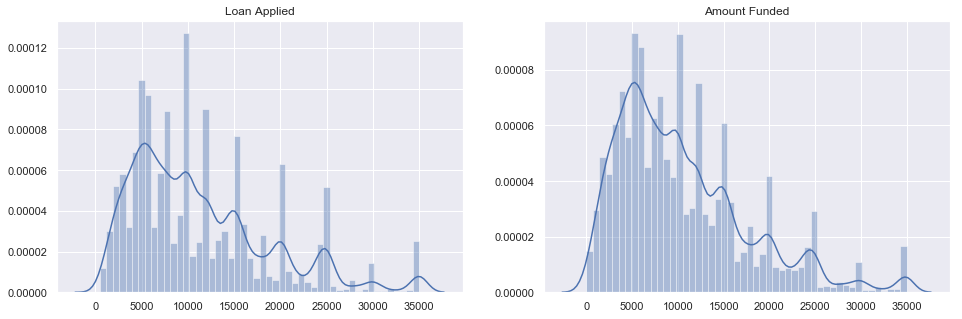

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))

loan_amount = loans_df["loan_amnt"].values
funded_amount = loans_df["funded_amnt_inv"].values


sns.distplot(loan_amount, ax=ax[0])
ax[0].set_title("Loan Applied", fontsize=12)
sns.distplot(funded_amount, ax=ax[1])
ax[1].set_title("Amount Funded", fontsize=12)

#### Grade and sub-grade

Text(0.5,1,'Type of Loans by Sub-Grade')

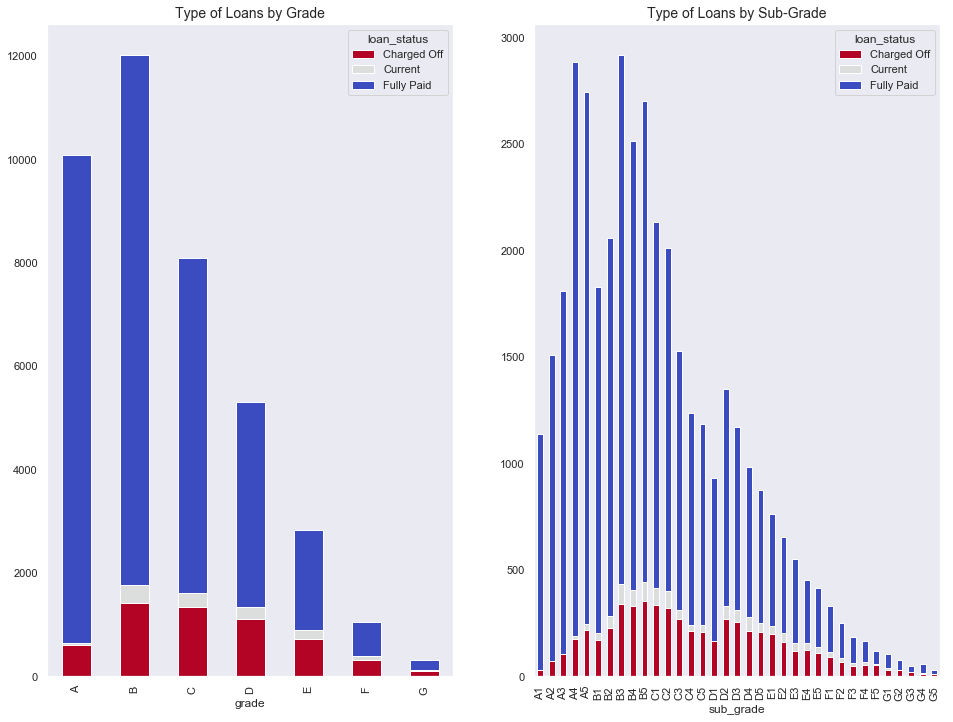

In [199]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

cmap = plt.cm.coolwarm_r

loans_by_region = loans_df.groupby(['grade', 'loan_status']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = loans_df.groupby(['sub_grade', 'loan_status']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)


#### Location

In [201]:
# loan_status per Region.
loan_status_cross = pd.crosstab(loans_df['addr_state_zip'], loans_df['loan_status']).apply(lambda x: x/x.sum() * 100)
number_of_loanstatus = pd.crosstab(loans_df['addr_state_zip'], loans_df['loan_status'])
number_of_loanstatus['Total'] = number_of_loanstatus.sum(axis=1)
number_of_loanstatus

loan_status,Charged Off,Current,Fully Paid,Total
addr_state_zip,,,,
AK_352xx,1,0,0,1
AK_363xx,0,0,1,1
AK_995xx,5,0,28,33
AK_996xx,2,1,10,13
AK_997xx,6,1,14,21
AK_998xx,0,0,10,10
AK_999xx,1,0,0,1
AL_350xx,5,1,51,57
AL_351xx,3,0,29,32


#### Interest Rate

In [202]:
#Checking for interest rate. Does it remain similar, or if it has high variance.
#Higher interest rate loans might be difficult to pay off.
loans_df.int_rate.head()

0    10.65%
1    15.27%
2    15.96%
3    13.49%
4    12.69%
Name: int_rate, dtype: object

In [203]:
#Removing % sign and convert all to float
loans_df.int_rate = loans_df.int_rate.map(lambda x: float(x.replace("%","")))

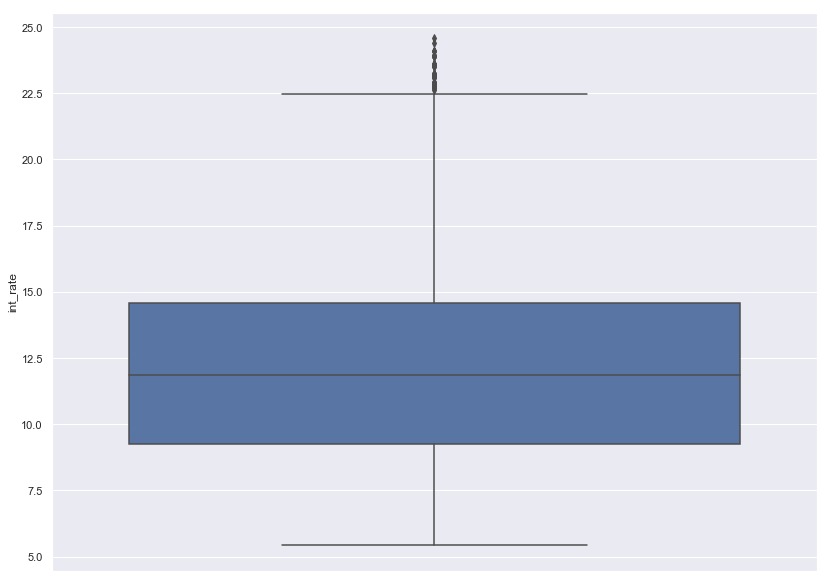

In [204]:
ax = sns.boxplot(y=loans_df.int_rate)

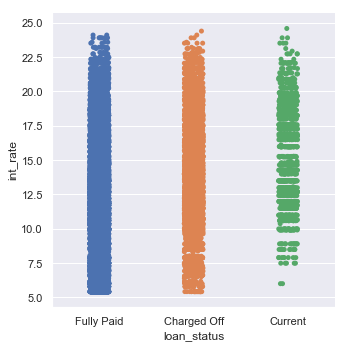

In [205]:
#It is clear that while most interest rates are between 9 and 14, there is a huge variance. Hence this can be a interesting parameter for analyisis
#Checking against loan_default_status
sns.catplot(x="loan_status", y="int_rate", data=loans_df);

In [206]:
#However, from the scatter plot we cannot say if interest rate is very affective to find if loan will default

#### Purpose

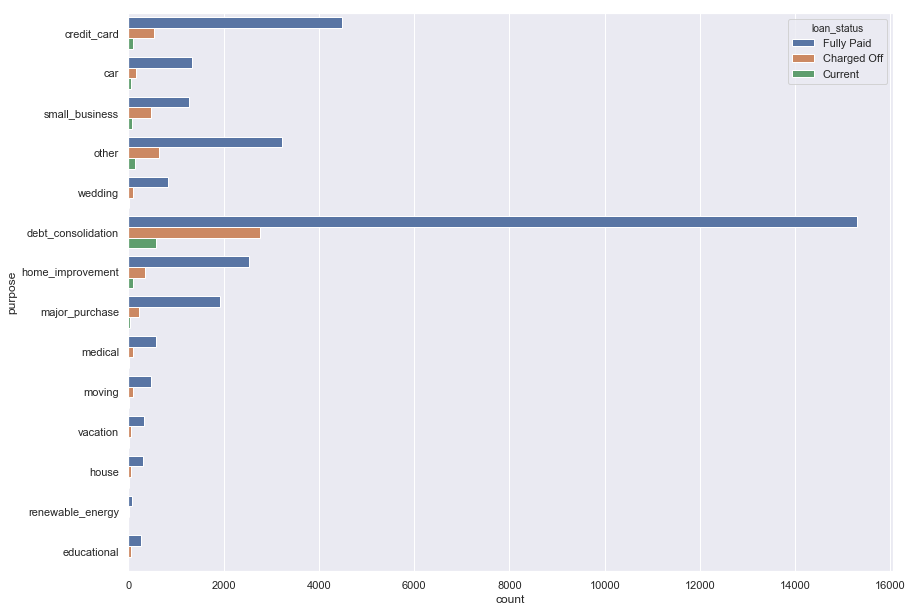

In [207]:
#Since this is a text column. Checking categories via a histplot
ax = sns.countplot(y="purpose", hue="loan_status", data=loans_df)

In [213]:
#Plotting Percentage of default loans (default/ default+fully paid) for each purpose
loans_purpose_df = loans_df[['id','purpose','loan_status']]
loans_purpose_pivot_df =loans_df.pivot_table(index='purpose',columns='loan_status', values='id',aggfunc='count',fill_value=0)
loans_purpose_pivot_df['default_ratio_loanscompleted%'] = (loans_purpose_pivot_df['Charged Off']/(loans_purpose_pivot_df['Fully Paid']+ loans_purpose_pivot_df['Charged Off']))*100
loans_purpose_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)


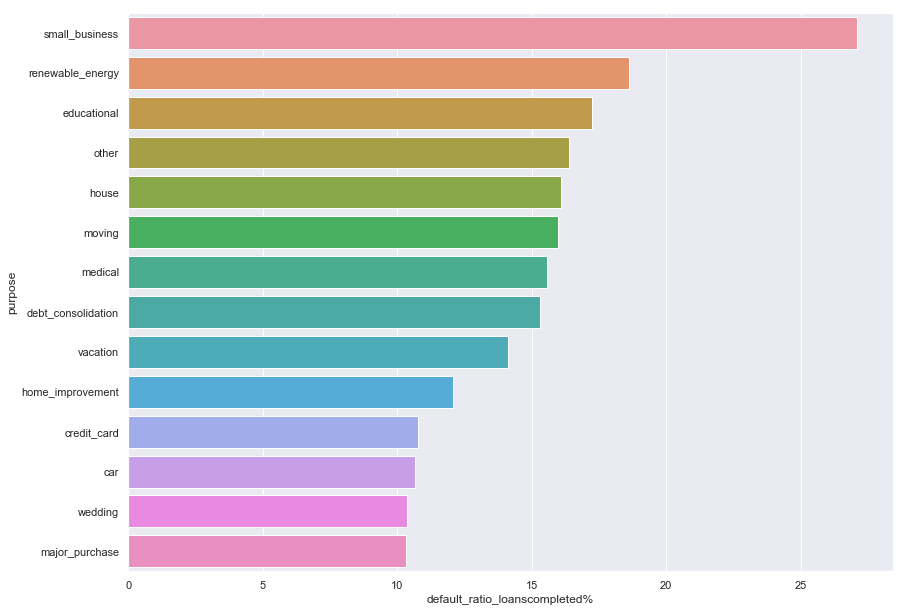

In [217]:
loans_purpose_pivot_df.head()
#loans_purpose_pivot_df.purpose.head()
ax = sns.barplot(y=loans_purpose_pivot_df.index, x="default_ratio_loanscompleted%", data=loans_purpose_pivot_df)


#### Ordinal Variable Analysis

In [211]:
#print(loans_df.columns)
for col in loans_df.columns:
    uniques = len(loans_df[col].unique())
    if uniques < 40:
        print(col,':',uniques,":", loans_df[col].unique())

term : 2 : [' 36 months' ' 60 months']
grade : 7 : ['B' 'C' 'A' 'E' 'F' 'D' 'G']
sub_grade : 35 : ['B2' 'C4' 'C5' 'C1' 'B5' 'A4' 'E1' 'F2' 'C3' 'B1' 'D1' 'A1' 'B3' 'B4'
 'C2' 'D2' 'A3' 'A5' 'D5' 'A2' 'E4' 'D3' 'D4' 'F3' 'E3' 'F4' 'F1' 'E5'
 'G4' 'E2' 'G3' 'G2' 'G1' 'F5' 'G5']
emp_length : 11 : [10.  0.  1.  3.  8.  9.  4.  5.  6.  2.  7.]
home_ownership : 5 : ['RENT' 'OWN' 'MORTGAGE' 'OTHER' 'NONE']
verification_status : 3 : ['Verified' 'Source Verified' 'Not Verified']
loan_status : 3 : ['Fully Paid' 'Charged Off' 'Current']
purpose : 14 : ['credit_card' 'car' 'small_business' 'other' 'wedding'
 'debt_consolidation' 'home_improvement' 'major_purchase' 'medical'
 'moving' 'vacation' 'house' 'renewable_energy' 'educational']
delinq_2yrs : 11 : [ 0  2  3  1  4  6  5  8  7  9 11]
inq_last_6mths : 9 : [1 5 2 0 3 4 6 7 8]
pub_rec : 5 : [0 1 2 3 4]
pub_rec_bankruptcies : 3 : [0. 1. 2.]


In [219]:
#Similar analysis for all ordinal variables
ordinal_variables = ['term','purpose', 'addr_state_zip','grade','sub_grade','home_ownership','verification_status']
loans_ordinal_pivot_df_arr = {}
min_loans = 5
for ordinal in ordinal_variables:
    loans_ordinal_df = loans_df[['id',ordinal,'loan_status']]
    loans_ordinal_pivot_df =loans_df.pivot_table(index=ordinal,columns='loan_status', values='id',aggfunc='count',fill_value=0)
    loans_ordinal_pivot_df['default_ratio_loanscompleted%'] = (loans_ordinal_pivot_df['Charged Off']/(loans_ordinal_pivot_df['Fully Paid']+ loans_ordinal_pivot_df['Charged Off']))*100
    loans_ordinal_pivot_df.sort_values(by='default_ratio_loanscompleted%', inplace=True, ascending=False)
    loans_ordinal_pivot_df = loans_ordinal_pivot_df.loc[loans_ordinal_pivot_df['Charged Off']+loans_ordinal_pivot_df['Fully Paid']>min_loans]
    loans_ordinal_pivot_df_arr[ordinal]= loans_ordinal_pivot_df
#Percentage of loans in each category

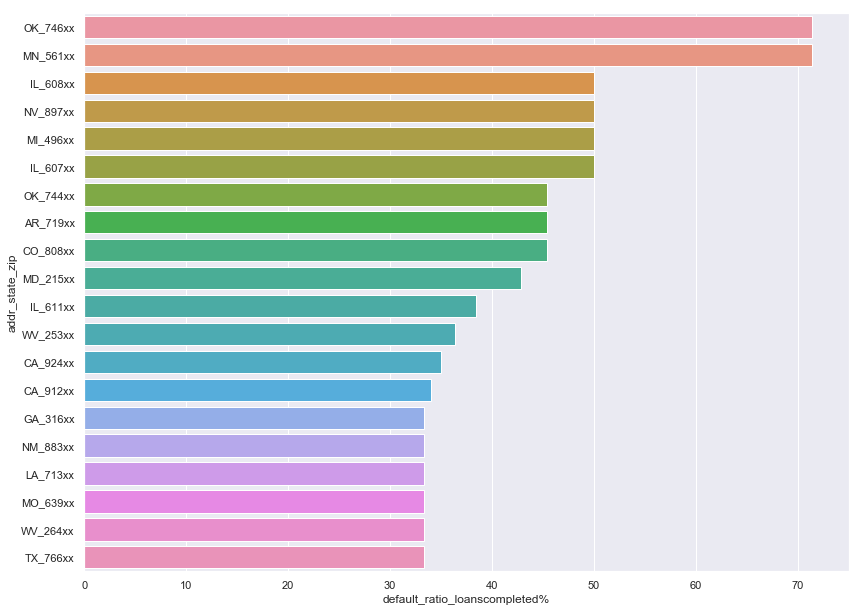

In [220]:
df_to_use =loans_ordinal_pivot_df_arr['addr_state_zip'].head(20)
ax = sns.barplot(y=df_to_use.index, x="default_ratio_loanscompleted%", data=df_to_use)

### Interval Variable Analysis

In [19]:
annual_inc, emp_length,
pub_rec,
pub_rec_bankruptcies,
inq_last_6mths
#No idea how to treat desc